In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
try:
    train_set
except:
    train_set = pd.read_csv("data/diabetes_train_set.csv")
    
train_set.shape

(81412, 50)

In [135]:
diabetes = train_set.copy()

admission_type_id
1.0    43139
3.0    15133
2.0    14839
6.0     4233
5.0     3784
8.0      265
7.0       10
4.0        9
Name: count, dtype: int64
discharge_disposition_id
1.0     48175
3.0     11191
6.0     10290
18.0     2958
2.0      1685
22.0     1585
11.0     1322
5.0       958
25.0      811
4.0       652
7.0       509
23.0      327
13.0      313
14.0      299
28.0      113
8.0        86
15.0       47
24.0       40
9.0        16
17.0       10
16.0        9
19.0        6
10.0        4
27.0        3
12.0        2
20.0        1
Name: count, dtype: int64
admission_source_id
7.0     45966
1.0     23668
17.0     5376
4.0      2589
6.0      1829
2.0       892
5.0       685
3.0       149
20.0      127
9.0        98
8.0        14
22.0        8
10.0        5
11.0        2
14.0        2
25.0        1
13.0        1
Name: count, dtype: int64
medical_specialty
?                         39948
InternalMedicine          11648
Emergency/Trauma           6059
Family/GeneralPractice     5913
Cardiol

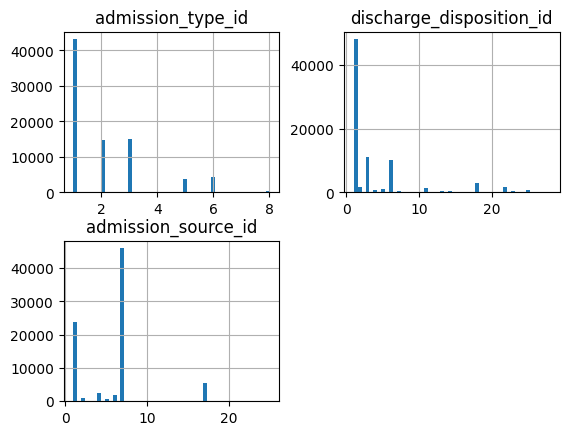

In [144]:
print(diabetes["admission_type_id"].value_counts())
print(diabetes["discharge_disposition_id"].value_counts())
print(diabetes["admission_source_id"].value_counts())
print(diabetes["medical_specialty"].value_counts())

diabetes[
    [
        "admission_type_id",
        "discharge_disposition_id",
        "admission_source_id",
        "medical_specialty",
    ]
].hist(bins=50)
plt.show()

____

In [208]:
diabetes = train_set.drop("readmitted", axis=1)
diabetes_labels = train_set["readmitted"].copy()
diabetes.shape

(81412, 49)

In [133]:
# Colunas com valores numéricos
print("Colunas com valores numéricos:", "\n", diabetes.select_dtypes("float64").columns.to_list(), "\n")

# Colunas com valores categóricos
print("Colunas com valores categóricos:", "\n", diabetes.select_dtypes("object").columns.to_list(), "\n")

Colunas com valores numéricos: 
 ['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses'] 

Colunas com valores categóricos: 
 ['race', 'gender', 'age', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'tolazamide', 'insulin', 'glyburide.metformin', 'glipizide.metformin', 'glimepiride.pioglitazone', 'metformin.pioglitazone', 'change', 'diabetesMed'] 



In [ ]:
# Fit

threshold = 0.2
null_mean = diabetes.isnull().mean()
null_columns = null_mean[null_mean > threshold].index.to_list()

null_mean = []
for col in diabetes.columns:
    mean = diabetes[diabetes[col] == '?'].shape[0] / diabetes.shape[0]
    if mean > threshold:
        null_columns.append(col)

null_columns

['max_glu_serum', 'A1Cresult', 'weight', 'payer_code', 'medical_specialty']

In [128]:
# Transform

# Remoção de colunas com muitos atributos núlos:
diabetes = diabetes.drop(null_columns, axis = 1)

In [ ]:
# Transform

# Removendo registros com valores nulos

diabetes.dropna(inplace=True)

diabetes = diabetes[diabetes["diag_1"] != "?"]
diabetes = diabetes[diabetes["diag_2"] != "?"]
diabetes = diabetes[diabetes["diag_3"] != "?"]
diabetes = diabetes[diabetes["race"] != "?"]
diabetes = diabetes[diabetes["gender"] != "Unknown/Invalid"]

diabetes.shape

(78430, 44)

In [130]:
# Fit

# Verifica quais são as colunas com apenas um valor
diabetes.loc[:, diabetes.nunique() == 1].columns.to_list()


['troglitazone', 'examide', 'citoglipton', 'metformin.rosiglitazone']

In [131]:
# Transform

diabetes = diabetes.loc[:, diabetes.nunique() != 1]
diabetes.shape

(78430, 40)

# Feature Engineering

In [ ]:
class GroupUncommon1HotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, attributes: list[str], threshold: float = 0.02):
        """
        Parâmetros:
            attributes: Lista das colunas a serem transformadas.
            threshold: Frequência mínima para que um valor seja considerado frequente.
        """
        self.attributes = attributes
        self.threshold = threshold

    def fit(self, X, y=None):
        # Dicionário para salvar os valores frequentes de cada coluna
        self.frequent_values_ = {}
        for col in self.attributes:
            # Calcula a frequência relativa dos valores
            value_counts = X[col].value_counts(normalize=True)
            # Seleciona os valores cuja frequência é maior ou igual ao threshold
            self.frequent_values_[col] = value_counts[
                value_counts >= self.threshold
            ].index.tolist()
        return self

    def transform(self, X):
        X = X.copy()  # Evita modificar o DataFrame original
        encoded_dfs = []  # Lista para armazenar os DataFrames one-hot encoded

        for col in self.attributes:
            # Obtém os valores frequentes para a coluna atual
            frequent = self.frequent_values_.get(col, [])
            # Substitui os valores raros por "Outros"
            X[col] = X[col].apply(lambda x: x if x in frequent else "Others")
            # Realiza o one-hot encoding usando pd.get_dummies
            dummies = pd.get_dummies(X[col], prefix=col)
            encoded_dfs.append(dummies)
            # Remove a coluna original, pois ela será substituída pelas dummies
            X = X.drop(columns=[col])

        # Concatena os dummies com o DataFrame original (com as demais colunas)
        X_transformed = pd.concat([X] + encoded_dfs, axis=1)
        return X_transformed

In [132]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names: list[str]):
        self.attribute_names = attribute_names
        pass
    def fit(self, X: pd.DataFrame, y: pd.DataFrame=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return X[self.attribute_names]

class RemoveNulls(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X: pd.DataFrame, y: pd.DataFrame=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return X.dropna()

class FeatureEngineering(BaseEstimator, TransformerMixin):
    """
    Dummy Implementation
    """
    
    def __init__(self):
        pass
    def fit(self, X: pd.DataFrame, y: pd.DataFrame=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        return X